In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

7.018992387946467 12.018992387946467 left-right threshold
Label SF is oriented Horizontal
[17, 18, 19, 20, 21, 22, 23, 24] patch summary
[26, 27, 28, 29, 30, 31, 32] patch summary
[33, 34, 35, 36, 37, 38, 39, 40] patch summary
[41, 42, 43, 44, 45, 46, 47, 48] patch summary


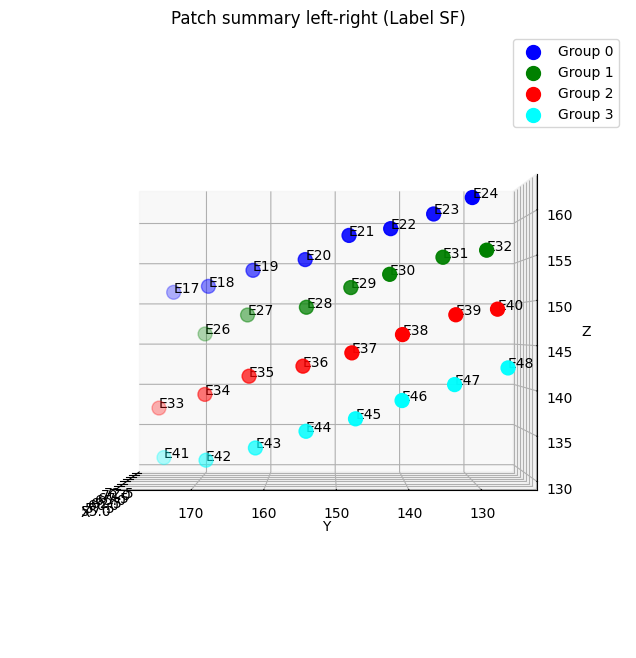

7.061586761945724 12.061586761945724 left-right threshold
Label LSF is oriented Horizontal
[56, 55, 54, 53, 52, 51, 50, 49] patch summary


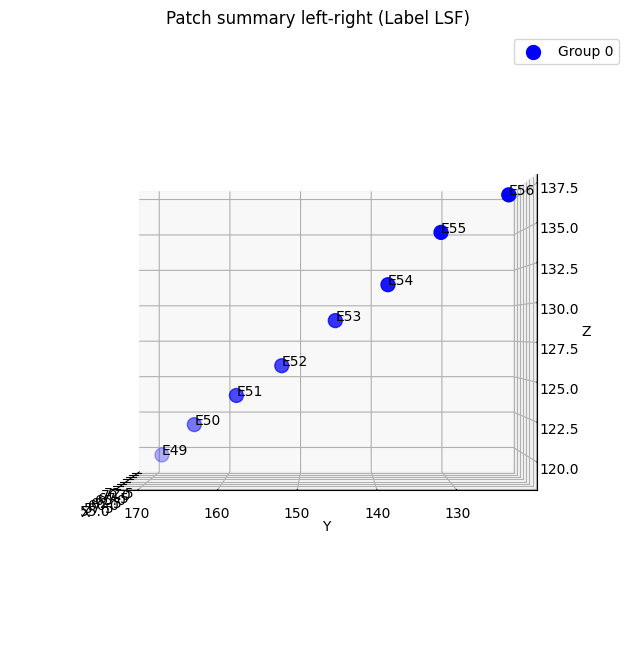

9.32050316381738 14.32050316381738 left-right threshold
Label PF is oriented Horizontal
[73, 74, 75, 76, 77] patch summary
[78, 79, 80, 81, 82] patch summary
[83, 84, 85, 86, 87] patch summary
[88, 89, 90, 91, 92] patch summary


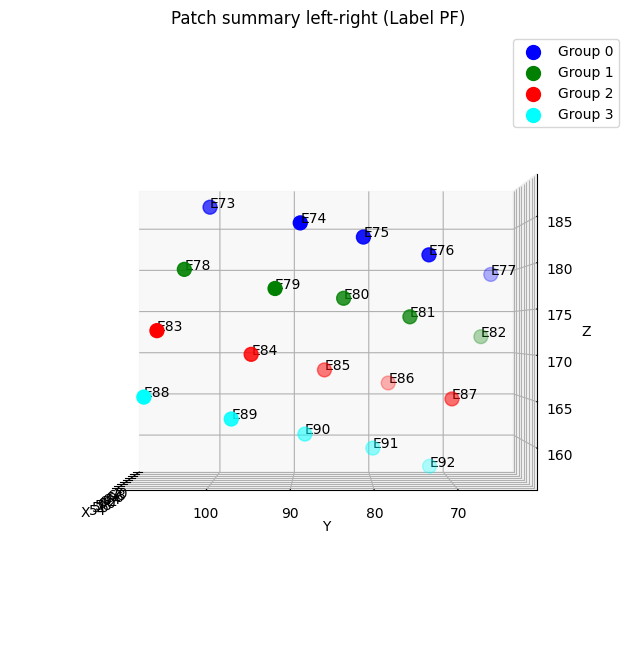

6.771895151438485 14.771895151438486 top-bottom threshold
Label ST is oriented Vertical
[[93, 94, 95, 96, 97], [98, 99, 100, 101, 102], [103, 104, 105, 106, 107], [108, 109, 110, 111, 112]] patch summary


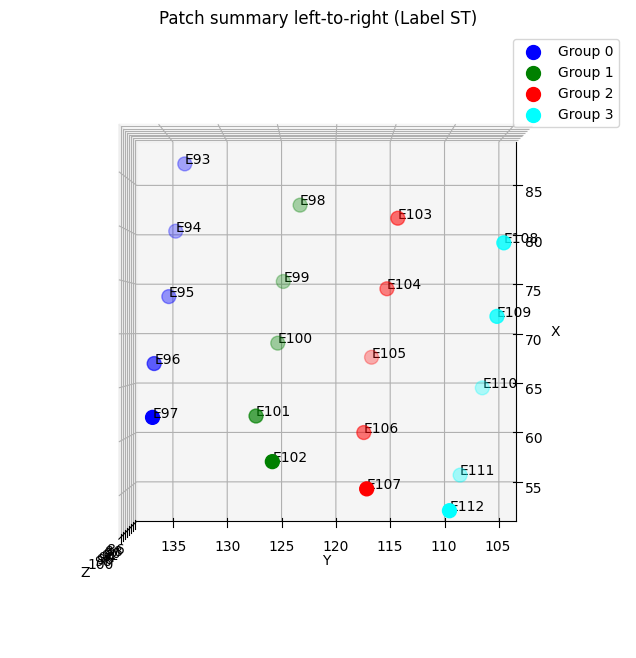

{'SF': {'view': 'left-right',
  'orientation': 'Horizontal',
  'matrix': [[17, 18, 19, 20, 21, 22, 23, 24],
   [None, 26, 27, 28, 29, 30, 31, 32],
   [33, 34, 35, 36, 37, 38, 39, 40],
   [41, 42, 43, 44, 45, 46, 47, 48]]},
 'LSF': {'view': 'left-right',
  'orientation': 'Horizontal',
  'matrix': [[56, 55, 54, 53, 52, 51, 50, 49]]},
 'PF': {'view': 'left-right',
  'orientation': 'Horizontal',
  'matrix': [[73, 74, 75, 76, 77],
   [78, 79, 80, 81, 82],
   [83, 84, 85, 86, 87],
   [88, 89, 90, 91, 92]]},
 'ST': {'view': 'top-bottom',
  'orientation': 'Vertical',
  'matrix': [[93, 98, 103, 108],
   [94, 99, 104, 109],
   [95, 100, 105, 110],
   [96, 101, 106, 111],
   [97, 102, 107, 112]]}}

In [6]:
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_2024.csv")
# electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_electrodes_2024.csv")

# ep129 top-bottom divided by region
top_bottom_df = electrode_df[electrode_df['E_Brain'].isin(['ST'])]
left_right_df = electrode_df[~electrode_df['E_Brain'].isin(['ST'])]

# ep187 top-bottom divided by region

# top_bottom_df = electrode_df[electrode_df['E_Brain'].isin(['PS', 'SF'])]
# left_right_df = electrode_df[~electrode_df['E_Brain'].isin(['PS', 'LO', 'PT', 'SF'])]
# front_back_df = electrode_df[electrode_df['E_Brain'].isin(['LO', 'PT'])]

# find the unique labels for creating arrays
top_bottom_df_array = top_bottom_df['E_Brain'].unique()
left_right_df_array = left_right_df['E_Brain'].unique()

# front_back_df_array = front_back_df['E_Brain'].unique()
# print(top_bottom_df_array, left_right_df_array, front_back_df_array, '????????')

# Initialize the final dictionary to store electrode groups
electrode_groups = {}

def update_electrode_groups(view, e_brain, matrix, orientation):
    # Update the electrode_groups dictionary
    electrode_groups[e_brain] = {'view': view, 'orientation': orientation, 'matrix': matrix}

# Determine whether it is horizontal or vertical when view is from left to right
def left_right_determine_orientation(group_df):
    y_std = group_df['Y'].std()
    z_std = group_df['Z'].std()

    if y_std > z_std:
        return "Horizontal"
    else:
        return "Vertical"

# Determine whether it is horizontal or vertical when view is from top to bottom
def top_bottom_determine_orientation(group_df):
    x_std = group_df['X'].std()
    y_std = group_df['Y'].std()

    if x_std > y_std:
        return "Vertical"
    else:
        return "Horizontal"

def front_back_determine_orientation(group_df):
    x_std = group_df['X'].std()
    z_std = group_df['Z'].std()

    if x_std > z_std:
        return "Horizontal"
    else:
        return "Vertical"

# Loop through each brain region for left and right view angle <============================================================================================================================
for e_brain in left_right_df_array:
    # Filter the dataframe for the current label
    filtered_df = left_right_df[left_right_df['E_Brain'] == e_brain]
    
    # Current label electrode dataframe
    sorted_df = filtered_df.sort_values(by='electrode_number')

    # Initialize a group label and assign group labels
    group_label = 0
    sorted_df['group'] = -1  

    # Calculate distances and define yz_threshold
    distances = np.sqrt((np.diff(sorted_df['Z'])**2) + (np.diff(sorted_df['Y'])**2))

    Q1, Q3 = np.percentile(distances, [25, 75])
    IQR = Q3 - Q1

    filtered_distances = distances[(distances >= Q1 - 1.5 * IQR) & (distances <= Q3 + 1.5 * IQR)]
    yz_threshold = np.mean(filtered_distances) + 5
    print(np.mean(filtered_distances), yz_threshold, 'left-right threshold')

    for i in range(len(sorted_df)):
        if i == 0:
            sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
        else:
            distance = np.sqrt((sorted_df.iloc[i]['Z'] - sorted_df.iloc[i-1]['Z'])**2 + (sorted_df.iloc[i]['Y'] - sorted_df.iloc[i-1]['Y'])**2)
            if distance > yz_threshold:
                group_label += 1
            sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
    
    # Visualization
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # left to right
    ax.view_init(elev=0, azim=180)

    unique_groups = sorted_df['group'].unique()

    #################################### if only one group for a e_brain ####################################
    if len(unique_groups) == 1: 
        group_df = sorted_df[sorted_df['group'] == unique_groups[0]]
        orientation = left_right_determine_orientation(group_df)
        print(f"Label {e_brain} is oriented {orientation}")

        # Update electrode_groups based on orientation
        if orientation == "Vertical":
            # Sort electrodes by Z-axis in descending order and place each in its own sublist
            sorted_electrodes = group_df.sort_values(by='Z', ascending=False)['electrode_number'].tolist()
            electrode_groups[str(e_brain)] = [[elec] for elec in sorted_electrodes]
            print(electrode_groups[str(e_brain)], 'patch summary')
            update_electrode_groups('left-right', str(e_brain), electrode_groups[str(e_brain)], orientation)

        else:
            # Sort electrodes by Y-axis in ascending order and place all in a single sublist
            sorted_electrodes = group_df.sort_values(by='Y', ascending=True)['electrode_number'].tolist()
            print(sorted_electrodes, 'patch summary')
            electrode_groups[str(e_brain)] = [sorted_electrodes]
            update_electrode_groups('left-right', e_brain, electrode_groups[str(e_brain)], orientation)


    #################################### if it has multiple groups ####################################
    else:
        # Determine the orientation of the first group
        first_group_df = sorted_df[sorted_df['group'] == unique_groups[0]]
        first_group_orientation = left_right_determine_orientation(first_group_df)
        print(f"Label {e_brain} is oriented {first_group_orientation}")

        # If the first group is horizontal, rearrange based on Z-axis average
        if first_group_orientation == "Horizontal":
            # Calculate the average Z-axis value for each group
            avg_z_by_group = sorted_df.groupby('group')['Z'].mean().sort_values(ascending=False)

            # Reorder the groups based on the sorted average Z-axis values
            reordered_groups = []
            for group in avg_z_by_group.index:
                group_electrodes = sorted_df[sorted_df['group'] == group].sort_values(by='Y', ascending=False)['electrode_number'].tolist()
                print(group_electrodes, 'patch summary')
                reordered_groups.append(group_electrodes)

            # Update the electrode_groups dictionary
            electrode_groups[str(e_brain)] = reordered_groups
            update_electrode_groups('left-right', str(e_brain), electrode_groups[str(e_brain)], first_group_orientation)

        else:
            # For vertical orientation
            # Calculate average Y-axis value for each group and sort the groups
            avg_y_by_group = sorted_df.groupby('group')['Y'].mean().sort_values(ascending=False)

            # Collect electrodes in each group in sorted order
            sorted_groups = [sorted_df[sorted_df['group'] == group].sort_values(by='Z', ascending=False)['electrode_number'].tolist() for group in avg_y_by_group.index]

            print(sorted_groups, 'patch summary')

            update_electrode_groups('left-right', str(e_brain), sorted_groups, first_group_orientation)

    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

    for group in unique_groups:
        group_df = sorted_df[sorted_df['group'] == group]
        color = colors[unique_groups.tolist().index(group)]
        ax.scatter(group_df['X'], group_df['Y'], group_df['Z'], s=100, color=color, label=f'Group {group}')
        for _, row in group_df.iterrows():
            ax.text(row['X'], row['Y'], row['Z'], f"E{row['electrode_number']}", color='black')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title(f'Patch summary left-right (Label {e_brain})')
    plt.legend()
    plt.show()


# Loop through each brain region for top and bottom view angle <============================================================================================================================
for e_brain in top_bottom_df_array:
    # Filter the dataframe for the current label
    filtered_df = top_bottom_df[top_bottom_df['E_Brain'] == e_brain]
    sorted_df = filtered_df.sort_values(by='electrode_number')

    # Initialize a group label and assign group labels
    group_label = 0
    sorted_df['group'] = -1  

    distances = np.sqrt((np.diff(sorted_df['X'])**2) + (np.diff(sorted_df['Y'])**2))

    Q1, Q3 = np.percentile(distances, [25, 75])
    
    IQR = Q3 - Q1


    # Consider points within 1.5 * IQR as non-outliers
    filtered_distances = distances[(distances >= Q1 - 1.5 * IQR) & (distances <= Q3 + 1.5 * IQR)]

    xy_threshold = np.mean(filtered_distances) + 8
    print(np.mean(filtered_distances), xy_threshold, 'top-bottom threshold')

    # Assign group labels
    for i in range(len(sorted_df)):
        if i == 0:
            sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
        else:
            distance = np.sqrt((sorted_df.iloc[i]['X'] - sorted_df.iloc[i-1]['X'])**2 + (sorted_df.iloc[i]['Y'] - sorted_df.iloc[i-1]['Y'])**2)
            if distance > xy_threshold:
                group_label += 1
                sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
            else:
                sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label


    # Plotting with color coding by group
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # top to bottom
    ax.view_init(elev=90, azim=180)
    
    unique_groups = sorted_df['group'].unique()

    #################################### if only one group for a e_brain ####################################
    if len(unique_groups) == 1: 
        group_df = sorted_df[sorted_df['group'] == unique_groups[0]]
        orientation = top_bottom_determine_orientation(group_df)
        print(f"Label {e_brain} is oriented {orientation}")

        # Update electrode_groups based on orientation
        if orientation == "Vertical":
            # Sort electrodes by X-axis in descending order and place each in its own sublist
            sorted_electrodes = group_df.sort_values(by='X', ascending=False)['electrode_number'].tolist()
            electrode_groups[str(e_brain)] = [[elec] for elec in sorted_electrodes]
            update_electrode_groups('top-bottom', str(e_brain), electrode_groups[str(e_brain)], orientation)
            print(electrode_groups[str(e_brain)], 'patch summary')
        else:
            # Sort electrodes by Y-axis in descending order and place all in a single sublist
            sorted_electrodes = group_df.sort_values(by='Y', ascending=False)['electrode_number'].tolist()
            electrode_groups[str(e_brain)] = [sorted_electrodes]
            update_electrode_groups('top-bottom', str(e_brain), electrode_groups[str(e_brain)], orientation)
            print(sorted_electrodes, 'patch summary')

    #################################### if it has multiple groups #########################################
    else:
        # Determine the orientation of the first group
        first_group_df = sorted_df[sorted_df['group'] == unique_groups[0]]
        first_group_orientation = top_bottom_determine_orientation(first_group_df)
        print(f"Label {e_brain} is oriented {first_group_orientation}")

        # If the first group is horizontal, rearrange based on X-axis average
        if first_group_orientation == "Horizontal":
            # Calculate the average X-axis value for each group
            avg_x_by_group = sorted_df.groupby('group')['X'].mean().sort_values(ascending=False)

            # Reorder the groups based on the sorted average X-axis values
            reordered_groups = []
            for group in avg_x_by_group.index:
                group_electrodes = sorted_df[sorted_df['group'] == group].sort_values(by='Y', ascending=True)['electrode_number'].tolist()
                print(group_electrodes, 'patch summary')
                reordered_groups.append(group_electrodes)

            # Update the electrode_groups dictionary
            electrode_groups[str(e_brain)] = reordered_groups
            update_electrode_groups('top-bottom', str(e_brain), electrode_groups[str(e_brain)], first_group_orientation)

        else:
            # For vertical orientation
            # Calculate average Y-axis value for each group and sort the groups
            avg_y_by_group = sorted_df.groupby('group')['Y'].mean().sort_values(ascending=False)

            # Collect electrodes in each group in sorted order
            sorted_groups = [sorted_df[sorted_df['group'] == group].sort_values(by='X', ascending=False)['electrode_number'].tolist() for group in avg_y_by_group.index]

            print(sorted_groups, 'patch summary')

            update_electrode_groups('top-bottom', str(e_brain), sorted_groups, first_group_orientation)

    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

    for group in unique_groups:
        group_df = sorted_df[sorted_df['group'] == group]
        color = colors[unique_groups.tolist().index(group)]
        ax.scatter(group_df['X'], group_df['Y'], group_df['Z'], s=100, color=color, label=f'Group {group}')
        for _, row in group_df.iterrows():
            ax.text(row['X'], row['Y'], row['Z'], f"E{row['electrode_number']}", color='black')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title(f'Patch summary left-to-right (Label {e_brain})')
    plt.legend()
    plt.show()


# Loop through each brain region for front and back view angle <============================================================================================================================
# for e_brain in front_back_df_array:
#     # Filter the dataframe for the current label
#     filtered_df = front_back_df[front_back_df['E_Brain'] == e_brain]
    
#     # Current label electrode dataframe
#     sorted_df = filtered_df.sort_values(by='electrode_number')

#     # Initialize a group label and assign group labels
#     group_label = 0
#     sorted_df['group'] = -1  

#     # Calculate distances and define xz_threshold
#     distances = np.sqrt((np.diff(sorted_df['Z'])**2) + (np.diff(sorted_df['X'])**2))

#     Q1, Q3 = np.percentile(distances, [25, 75])
#     IQR = Q3 - Q1

#     filtered_distances = distances[(distances >= Q1 - 1.5 * IQR) & (distances <= Q3 + 1.5 * IQR)]
#     yz_threshold = np.mean(filtered_distances) + 5
#     print(np.mean(filtered_distances), yz_threshold, 'front-back threshold')

#     for i in range(len(sorted_df)):
#         if i == 0:
#             sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
#         else:
#             distance = np.sqrt((sorted_df.iloc[i]['Z'] - sorted_df.iloc[i-1]['Z'])**2 + (sorted_df.iloc[i]['X'] - sorted_df.iloc[i-1]['X'])**2)
#             if distance > yz_threshold:
#                 group_label += 1
#             sorted_df.iloc[i, sorted_df.columns.get_loc('group')] = group_label
    
#     # Visualization
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')

#     # front to back
#     ax.view_init(elev=0, azim=90)

#     unique_groups = sorted_df['group'].unique()

#     #################################### if only one group for a e_brain ####################################
#     if len(unique_groups) == 1: 
#         group_df = sorted_df[sorted_df['group'] == unique_groups[0]]
#         orientation = front_back_determine_orientation(group_df)
#         print(f"Label {e_brain} is oriented {orientation}")

#         # Update electrode_groups based on orientation
#         if orientation == "Vertical":
#             # Sort electrodes by Z-axis in descending order and place each in its own sublist
#             sorted_electrodes = group_df.sort_values(by='Z', ascending=False)['electrode_number'].tolist()
#             electrode_groups[str(e_brain)] = [[elec] for elec in sorted_electrodes]
#             print(electrode_groups[str(e_brain)], 'patch summary')
#             update_electrode_groups('front-back', str(e_brain), electrode_groups[str(e_brain)], orientation)

#         else:
#             # Sort electrodes by Y-axis in ascending order and place all in a single sublist
#             sorted_electrodes = group_df.sort_values(by='X', ascending=True)['electrode_number'].tolist()
#             print(sorted_electrodes, 'patch summary')
#             electrode_groups[str(e_brain)] = [sorted_electrodes]
#             update_electrode_groups('front-back', e_brain, electrode_groups[str(e_brain)], orientation)


#     #################################### if it has multiple groups ####################################
#     else:
#         # Determine the orientation of the first group
#         first_group_df = sorted_df[sorted_df['group'] == unique_groups[0]]
#         first_group_orientation = front_back_determine_orientation(first_group_df)
#         print(f"Label {e_brain} is oriented {first_group_orientation}")

#         # If the first group is horizontal, rearrange based on Z-axis average
#         if first_group_orientation == "Horizontal":
#             # Calculate the average Z-axis value for each group
#             avg_z_by_group = sorted_df.groupby('group')['Z'].mean().sort_values(ascending=False)

#             # Reorder the groups based on the sorted average Z-axis values
#             reordered_groups = []
#             for group in avg_z_by_group.index:
#                 group_electrodes = sorted_df[sorted_df['group'] == group].sort_values(by='X', ascending=False)['electrode_number'].tolist()
#                 print(group_electrodes, 'patch summary')
#                 reordered_groups.append(group_electrodes)

#             # Update the electrode_groups dictionary
#             electrode_groups[str(e_brain)] = reordered_groups
#             update_electrode_groups('front-back', str(e_brain), electrode_groups[str(e_brain)], first_group_orientation)

#         else:
#             # For vertical orientation
#             # Calculate average X-axis value for each group and sort the groups
#             avg_y_by_group = sorted_df.groupby('group')['X'].mean().sort_values(ascending=False)

#             # Collect electrodes in each group in sorted order
#             sorted_groups = [sorted_df[sorted_df['group'] == group].sort_values(by='Z', ascending=False)['electrode_number'].tolist() for group in avg_y_by_group.index]

#             print(sorted_groups, 'patch summary')

#             update_electrode_groups('front-back', str(e_brain), sorted_groups, first_group_orientation)

#     colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

#     for group in unique_groups:
#         group_df = sorted_df[sorted_df['group'] == group]
#         color = colors[unique_groups.tolist().index(group)]
#         ax.scatter(group_df['X'], group_df['Y'], group_df['Z'], s=100, color=color, label=f'Group {group}')
#         for _, row in group_df.iterrows():
#             ax.text(row['X'], row['Y'], row['Z'], f"E{row['electrode_number']}", color='black')

#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     plt.title(f'Patch summary front-back (Label {e_brain})')
#     plt.legend()
#     plt.show()

electrode_positions = {row['electrode_number']: {'X': row['X'], 'Y': row['Y'], 'Z': row['Z']}
                       for index, row in electrode_df.iterrows()}

def calculate_distance(e1, e2, orientation):
    # Extract coordinates
    pos1, pos2 = electrode_positions[e1], electrode_positions[e2]
    if orientation == 'Horizontal':
        # Calculate distance in the Y-Z plane
        return np.sqrt((pos1['Y'] - pos2['Y'])**2 + (pos1['Z'] - pos2['Z'])**2)
    else:
        # Calculate distance in the X-Y plane
        return np.sqrt((pos1['X'] - pos2['X'])**2 + (pos1['Y'] - pos2['Y'])**2)

def align_matrix(matrix, orientation):
    # Identify the row with the maximum electrodes
    max_row_length = max(len(row) for row in matrix)
    longest_row = max(matrix, key=len)

    # Initialize aligned matrix with placeholders
    aligned_matrix = [[None]*max_row_length for _ in range(len(matrix))]

    for i, row in enumerate(matrix):
        for j, electrode in enumerate(row):
            if len(row) == max_row_length:
                # Directly copy the longest row to the aligned matrix
                aligned_matrix[i][j] = electrode
            else:
                # Find the closest electrode in the longest row
                distances = [calculate_distance(electrode, e, orientation) for e in longest_row]
                min_distance_index = distances.index(min(distances))
                # Place electrode in the column of the closest electrode
                aligned_matrix[i][min_distance_index] = electrode

    return aligned_matrix

# Align matrices in electrode_groups based on spatial coordinates
for label, group_info in electrode_groups.items():
    aligned_matrix = align_matrix(group_info['matrix'], group_info['orientation'])
    electrode_groups[label]['matrix'] = aligned_matrix

# Only transform matrices for labels with 'Vertical' orientation and more than one row
def transpose_and_pair_vertical_matrices_conditionally(electrode_groups):
    for label, info in electrode_groups.items():
        if info['orientation'] == 'Vertical':
            original_matrix = info['matrix']
            # Check if the matrix represents more than one row
            is_multi_row = len(original_matrix) > 1 and any(len(row) > 1 for row in original_matrix)

            # Only proceed with matrices that are not a single vertical line
            if is_multi_row:
                # Find the maximum length among all rows
                max_length = max(len(row) for row in original_matrix)
                transposed_matrix = []
                
                # Transpose the matrix
                for i in range(max_length):
                    new_row = [row[i] if i < len(row) else None for row in original_matrix]
                    transposed_matrix.append(new_row)
                
                # Update the matrix in the original dictionary
                info['matrix'] = transposed_matrix

transpose_and_pair_vertical_matrices_conditionally(electrode_groups)

# Save
with open('ep129_region_summary.json', 'w') as f:
    json.dump(electrode_groups, f)

# with open('ep187_region_summary.json', 'w') as f:
#     json.dump(electrode_groups, f)

# Display
electrode_groups
